In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import optimize
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [6]:
data=pd.read_csv("D:/MaestriaEA/Analisis de Datos/NEW-DATA/NEW-DATA-1.T15.txt",delimiter=" ")
data1=data.copy()
data=data.select_dtypes(include=["int64","float64"])

**Coeficiente línea de correlación**

C:\Users\hmarbello\AppData\Local\Temp\ipykernel_4692\88105251.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))


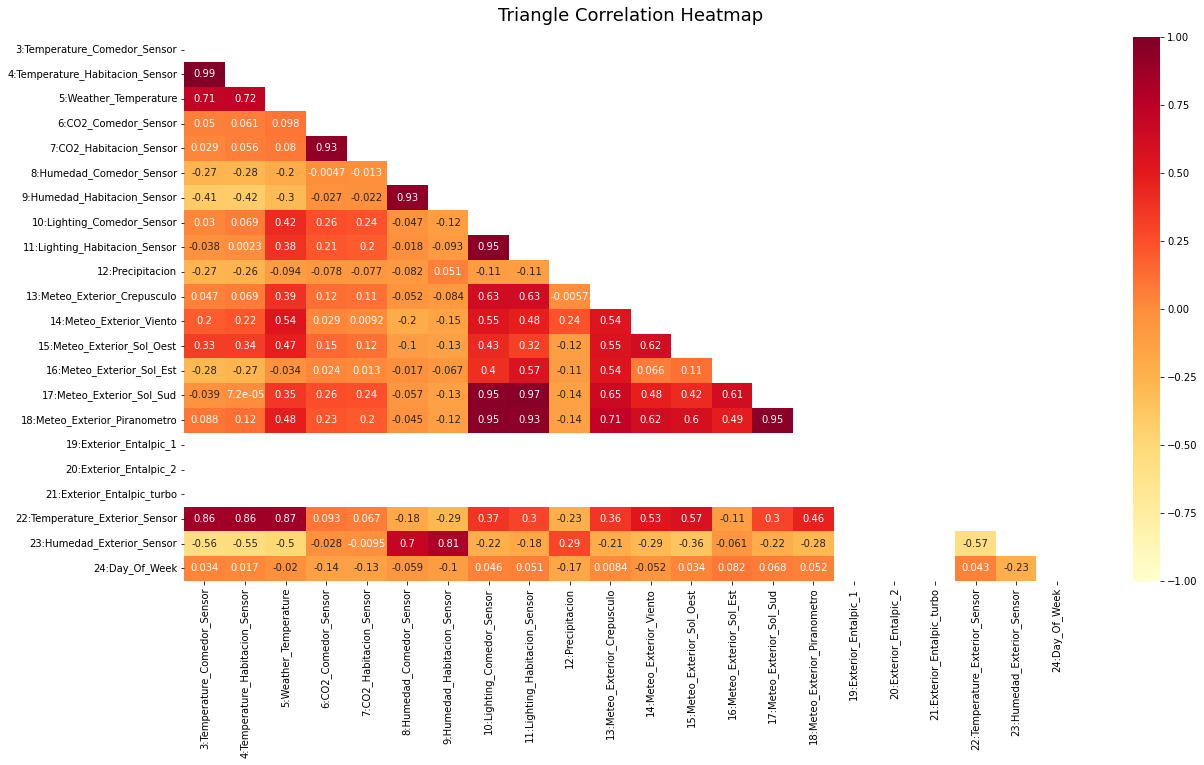

In [13]:
plt.figure(figsize=(20,10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='YlOrRd')#cmap=BrBG
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

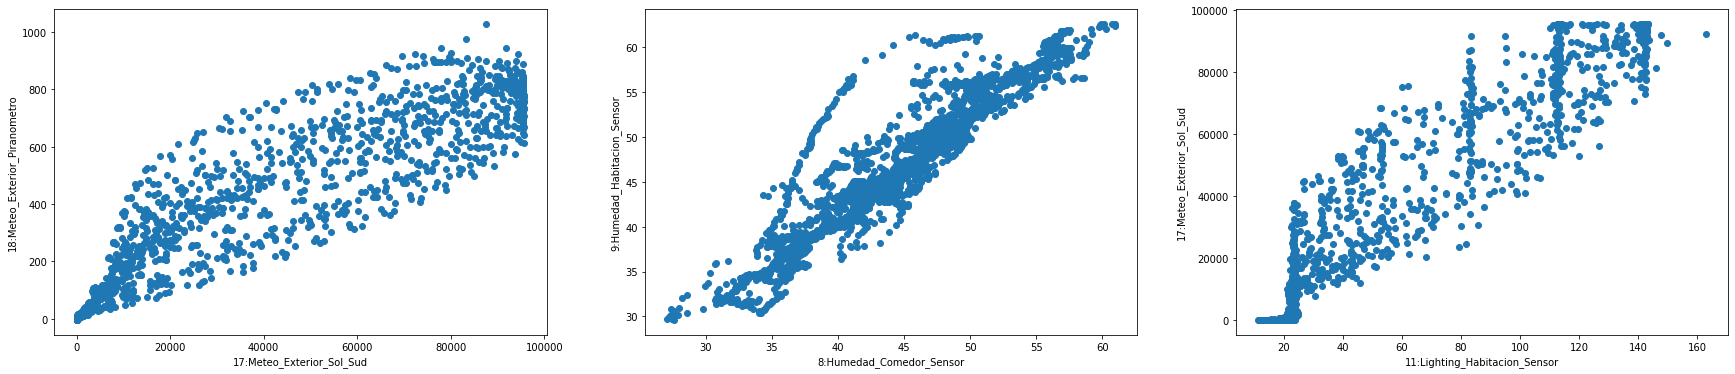

In [21]:
plt.figure(figsize=(30,6))
plt.subplot(131)
plt.scatter(data["17:Meteo_Exterior_Sol_Sud"],data["18:Meteo_Exterior_Piranometro"])
plt.xlabel("17:Meteo_Exterior_Sol_Sud")
plt.ylabel("18:Meteo_Exterior_Piranometro")
plt.subplot(132)
plt.scatter(data["8:Humedad_Comedor_Sensor"],data["9:Humedad_Habitacion_Sensor"])
plt.xlabel("8:Humedad_Comedor_Sensor")
plt.ylabel("9:Humedad_Habitacion_Sensor")
plt.subplot(133)
plt.scatter(data["11:Lighting_Habitacion_Sensor"],data["17:Meteo_Exterior_Sol_Sud"])
plt.xlabel("11:Lighting_Habitacion_Sensor")
plt.ylabel("17:Meteo_Exterior_Sol_Sud")
plt.show()


In [23]:
def f( x, p0, p1):
    return p0+p1*x

def ff(x, p):
    return f(x, *p)

In [63]:
def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=1, epsfcn=0.0001)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
            error.append(np.absolute(pcov[i][i])**0.5)
        except:
            error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

# These are the true parameters
p0,p1 = 1.0, 1.0
# These are initial guesses for fits:
pstart = [p0+random.random(),p1+random.random()]
#pfit, perr = fit_leastsq(pstart, data["17:Meteo_Exterior_Sol_Sud"], data["11:Lighting_Habitacion_Sensor"], ff)
pfitLS, perrLS = fit_leastsq(pstart, data["11:Lighting_Habitacion_Sensor"], data["17:Meteo_Exterior_Sol_Sud"], ff)
print("\n# Fit parameters and parameter errors from lestsq method :")
print("pfit = ", pfitLS)
print("perr = ", perrLS)


# Fit parameters and parameter errors from lestsq method :
pfit =  [-8344.56784258   746.13738055]
perr =  [224.89349732   3.82884573]


In [62]:
err_stdev = 0.2
def fit_curvefit(p0, datax, datay, function, yerr=err_stdev, **kwargs):
    """
    Note: As per the current documentation (Scipy V1.1.0), sigma (yerr) must be:
        None or M-length sequence or MxM array, optional
    Therefore, replace:
        err_stdev = 0.2
    With:
        err_stdev = [0.2 for item in xdata]
    Or similar, to create an M-length sequence for this example.
    """
    pfit, pcov = optimize.curve_fit(f,datax,datay,p0=p0, sigma=None, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
            error.append(np.absolute(pcov[i][i])**0.5)
        except:
            error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit 

pfitCF, perrCF = fit_curvefit(pstart, data["11:Lighting_Habitacion_Sensor"], data["17:Meteo_Exterior_Sol_Sud"], ff)

print("\n# Fit parameters and parameter errors from curve_fit method :")
print("pfit = ", pfitCF)
print("perr = ", perrCF)


# Fit parameters and parameter errors from curve_fit method :
pfit =  [-8344.56784258   746.13738055]
perr =  [224.89349732   3.82884573]


In [60]:
def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta
        randomfit, randomcov = optimize.leastsq(errfunc, p0, args=(datax, randomdataY), full_output=0)
        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 1. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap 

pfitBS, perrBS = fit_bootstrap(pstart, data["11:Lighting_Habitacion_Sensor"], data["17:Meteo_Exterior_Sol_Sud"], ff)

print("\n# Fit parameters and parameter errors from bootstrap method :")
print("pfit = ", pfitBS)
print("perr = ", perrBS)


# Fit parameters and parameter errors from bootstrap method :
pfit =  [-8365.4783448   746.4819612]
perr =  [232.13275402   3.74719089]


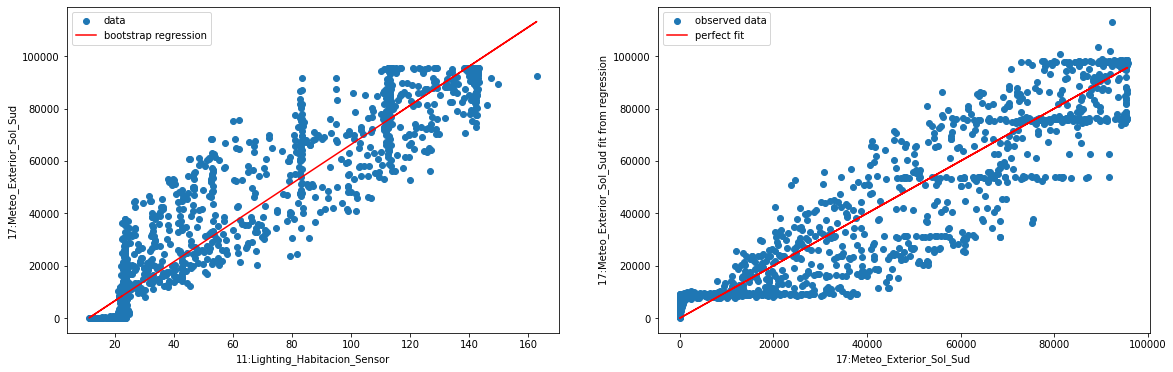

In [49]:
plt.figure(figsize=(30,6))
plt.subplot(131)
plt.scatter(data["11:Lighting_Habitacion_Sensor"],data["17:Meteo_Exterior_Sol_Sud"],label="data")
x0=data["11:Lighting_Habitacion_Sensor"]#np.linspace(data["G3"].min(),data["G3"].max(),7)
plt.plot(x0,f(x0,*pfit),color="r",label="bootstrap regression")
plt.xlabel("11:Lighting_Habitacion_Sensor")
plt.ylabel("17:Meteo_Exterior_Sol_Sud")
plt.legend()
plt.subplot(132)
plt.scatter(data["17:Meteo_Exterior_Sol_Sud"],f(x0,*pfit),label="observed data")
x0=data["17:Meteo_Exterior_Sol_Sud"]#np.linspace(data["G3"].min(),data["G3"].max(),7)
plt.plot(x0,x0,color="r",label="perfect fit")
plt.xlabel("17:Meteo_Exterior_Sol_Sud")
plt.ylabel("17:Meteo_Exterior_Sol_Sud fit from regression")
plt.legend()
plt.show()

**Coeficiente de Determinación Machine Learning**

In [40]:
r2 = r2_score(data["17:Meteo_Exterior_Sol_Sud"], f(x0,*pfit))
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.9321996590199507


**Coeficiente de Determinación**

In [43]:
def r2_hand(y,yhat):
    SST=np.sum((y-np.mean(y))**2)
    SSE=np.sum((y-yhat)**2)
    R2=(SST-SSE)/SST
    return R2
print('r2 score for perfect model is', r2_hand(data["17:Meteo_Exterior_Sol_Sud"], f(x0,*pfit)))

r2 score for perfect model is 0.9321996590199507


**Otras opciones**

In [48]:
X = data['11:Lighting_Habitacion_Sensor']   # independent variables
y = data['17:Meteo_Exterior_Sol_Sud']   # dependent variables

# to get intercept -- this is optional
X = sm.add_constant(X)

# fit the regression model
reg = sm.OLS(y, X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     17:Meteo_Exterior_Sol_Sud   R-squared:                       0.932
Model:                                   OLS   Adj. R-squared:                  0.932
Method:                        Least Squares   F-statistic:                 3.798e+04
Date:                       Sat, 09 Apr 2022   Prob (F-statistic):               0.00
Time:                               14:26:28   Log-Likelihood:                -28935.
No. Observations:                       2764   AIC:                         5.787e+04
Df Residuals:                           2762   BIC:                         5.789e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -8344.5678    224.893    -37.105      0.000   -8785.544   -7903.591
11:Lighting_Habitacion_Sensor   746.1374      3.829    194.873      0.000     738.630     753.645
==============================================================================
Omnibus:                      782.632   Durbin-Watson:                   0.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2627.557
Skew:                           1.402   Prob(JB):                         0.00
Kurtosis:                       6.867   Cond. No.                         81.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**O incluso tomando muchas más variables**

In [50]:
X = data[['11:Lighting_Habitacion_Sensor','8:Humedad_Comedor_Sensor',"9:Humedad_Habitacion_Sensor","18:Meteo_Exterior_Piranometro"]]   # independent variables
y = data['17:Meteo_Exterior_Sol_Sud']   # dependent variables

# to get intercept -- this is optional
X = sm.add_constant(X)

# fit the regression model
reg = sm.OLS(y, X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     17:Meteo_Exterior_Sol_Sud   R-squared:                       0.951
Model:                                   OLS   Adj. R-squared:                  0.951
Method:                        Least Squares   F-statistic:                 1.334e+04
Date:                       Sat, 09 Apr 2022   Prob (F-statistic):               0.00
Time:                               14:40:08   Log-Likelihood:                -28491.
No. Observations:                       2764   AIC:                         5.699e+04
Df Residuals:                           2759   BIC:                         5.702e+04
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           319.4172    962.435      0.332      0.740   -1567.749    2206.583
11:Lighting_Habitacion_Sensor   485.3613      9.039     53.696      0.000     467.637     503.085
8:Humedad_Comedor_Sensor          3.7852     58.607      0.065      0.949    -111.133     118.703
9:Humedad_Habitacion_Sensor    -141.5784     51.359     -2.757      0.006    -242.285     -40.872
18:Meteo_Exterior_Piranometro    39.4767      1.290     30.609      0.000      36.948      42.006
==============================================================================
Omnibus:                      394.814   Durbin-Watson:                   0.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1381.656
Skew:                           0.695   Prob(JB):                    9.49e-301
Kurtosis:                       6.173   Cond. No.                     2.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Ahora usamos Machine Learning!**

In [51]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [52]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [53]:
y_prediction =  LR.predict(x_test)
y_prediction

array([-9.49159033e+02, -8.29491031e+02, -7.08990922e+02,  5.61909051e+02,
        7.01274385e+04,  1.24828760e+04,  1.71695204e+03,  7.31744923e+03,
        1.71288984e+04, -6.99106151e+02, -5.62211094e+02,  9.74330718e+04,
        5.21805538e+02,  1.11278173e+04,  6.18369823e+04,  9.18443315e+00,
        4.71091012e+04,  7.48321204e+02, -1.26391829e+03,  6.25540579e+04,
        1.89164346e+04,  7.60841826e+04, -1.51842358e+02, -1.89044623e+03,
        4.77326790e+04,  2.00737621e+03, -1.28211365e+03, -7.22525619e+02,
       -2.75075836e+02,  7.02101310e+03,  9.10147474e+02,  3.15204502e+04,
        6.91141902e+03,  7.74402792e+02,  3.13308016e+04,  1.26145524e+03,
        7.04817493e+03,  1.70092997e+04,  3.18451662e+04,  2.72192701e+04,
       -4.54234733e+02,  9.28486815e+04, -7.42991882e+02, -1.51435773e+03,
       -1.12964945e+03, -1.00726228e+03, -6.28224840e+02,  2.71794393e+03,
        7.63343079e+02,  9.50697584e+04,  5.97678615e+04,  8.96141931e+03,
        4.50072990e+02,  

In [54]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print("r2 socre is ",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_prediction))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is  0.9446145844532452
mean_sqrd_error is== 52837517.193841435
root_mean_squared error of is== 7268.941958348645


In [55]:
y_prediction_all =  LR.predict(X)

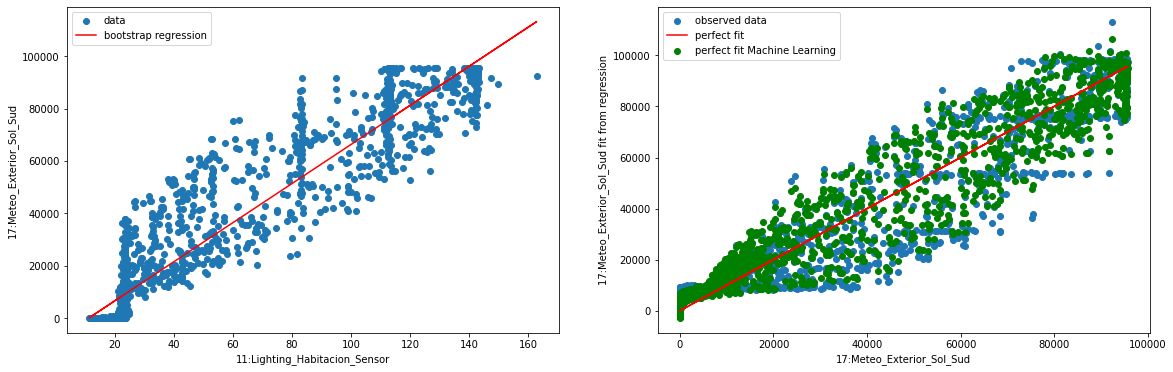

In [58]:
plt.figure(figsize=(30,6))
plt.subplot(131)
plt.scatter(data["11:Lighting_Habitacion_Sensor"],data["17:Meteo_Exterior_Sol_Sud"],label="data")
x0=data["11:Lighting_Habitacion_Sensor"]#np.linspace(data["G3"].min(),data["G3"].max(),7)
plt.plot(x0,f(x0,*pfit),color="r",label="bootstrap regression")
plt.xlabel("11:Lighting_Habitacion_Sensor")
plt.ylabel("17:Meteo_Exterior_Sol_Sud")
plt.legend()
plt.subplot(132)
plt.scatter(data["17:Meteo_Exterior_Sol_Sud"],f(x0,*pfit),label="observed data")
x0=data["17:Meteo_Exterior_Sol_Sud"]#np.linspace(data["G3"].min(),data["G3"].max(),7)
plt.plot(x0,x0,color="r",label="perfect fit")
plt.scatter(y,y_prediction_all,color="g",label="perfect fit Machine Learning")
plt.xlabel("17:Meteo_Exterior_Sol_Sud")
plt.ylabel("17:Meteo_Exterior_Sol_Sud fit from regression")
plt.legend()
plt.show()


In [59]:
# predicting the accuracy score
score=r2_score(y,y_prediction_all)
print("r2 socre is ",score)
print("mean_sqrd_error is==",mean_squared_error(y,y_prediction_all))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y,y_prediction_all)))

r2 socre is  0.9508335458768092
mean_sqrd_error is== 52584354.37765547
root_mean_squared error of is== 7251.507041826235


**Puntos A y B**

In [85]:
pd.DataFrame([pfitBS,pfitCF,pfitLS],columns=["A","B"],index=["BootStrap","CurveFit","LeaDtsq"])


,A,B
BootStrap,-8365.478345,746.481961
CurveFit,-8344.567843,746.137381
LeaDtsq,-8344.567843,746.137381


**Error**

In [87]:
#pd.DataFrame([pfitBS,perrBS,pfitCF,perrCF,pfitLS,perrLS],columns=["A","B"])
df=pd.DataFrame([perrBS,perrCF,perrLS],columns=["A","B"],index=["BootStrap","CurveFit","LeaDtsq"])
from IPython.display import HTML, display_html, display
display(HTML('<h2>Errores</h2>'))
display_html(df)

,A,B
BootStrap,232.132754,3.747191
CurveFit,224.893497,3.828846
LeaDtsq,224.893497,3.828846


**Porcentaje de Error**

In [93]:
df=pd.DataFrame([(perrBS/pfitBS),perrCF/pfitCF,perrLS/pfitLS],columns=["A","B"],index=["BootStrap","CurveFit","LeaDtsq"])*100
display(HTML('<h2>Porcentaje de Error</h2>'))
display_html(df)

,A,B
BootStrap,-2.774889,0.501980
CurveFit,-2.695089,0.513156
LeaDtsq,-2.695089,0.513156


In [82]:
pd.DataFrame([perrBS/pfitBS,perrCF/pfitCF,perrLS/pfitLS],columns=["A","B"],index=["BootStrap","CurveFit","LeaDtsq"])

,A,B
BootStrap,-0.027749,0.005020
CurveFit,-0.026951,0.005132
LeaDtsq,-0.026951,0.005132
